Loading Mall Customers Dataset...
   customer_id  gender  age  annual_income_k  spending_score
0            1    Male   19               15              39
1            2    Male   21               15              81
2            3  Female   20               16               6
3            4  Female   23               16              77
4            5  Female   31               17              40

Features used for segmentation: ['age', 'annual_income_k', 'spending_score']

Evaluating optimal number of clusters...
K=2 | Inertia=389.39 | Silhouette=0.3355
K=3 | Inertia=295.99 | Silhouette=0.3547
K=4 | Inertia=252.65 | Silhouette=0.3515
K=5 | Inertia=169.89 | Silhouette=0.4085
K=6 | Inertia=133.87 | Silhouette=0.4274
K=7 | Inertia=120.47 | Silhouette=0.4090
K=8 | Inertia=110.70 | Silhouette=0.3942
K=9 | Inertia=95.66 | Silhouette=0.4227
K=10 | Inertia=94.68 | Silhouette=0.3699


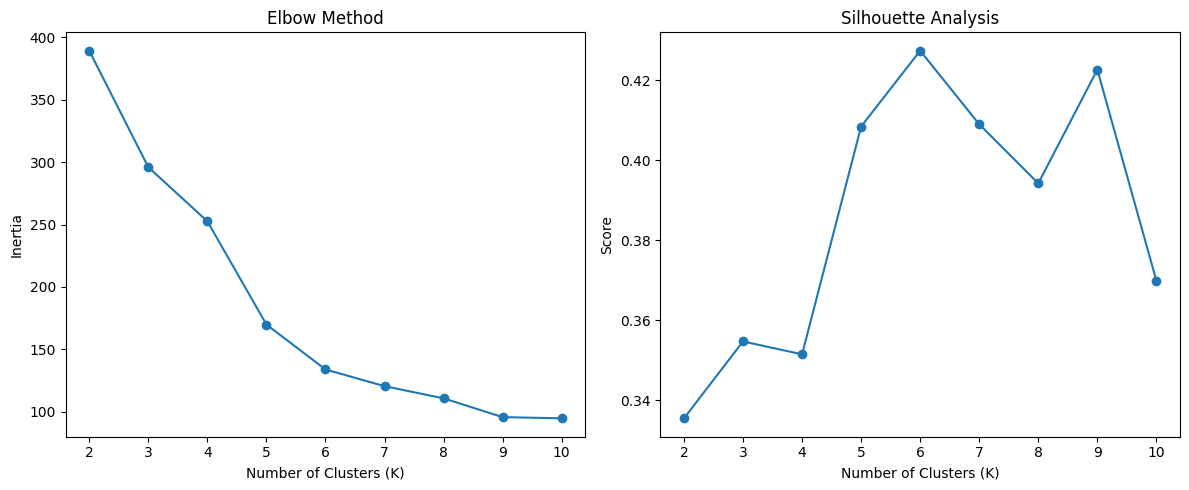


Optimal number of clusters selected: 6

Cluster Centroids (Original Scale):
               age  annual_income_k  spending_score
Segment                                            
0        25.185185        41.092593       62.240741
1        30.000000        85.176471       18.647059
2        32.692308        86.538462       82.128205
3        54.937500        54.375000       49.187500
4        48.318182        87.500000       19.590909
5        46.250000        26.750000       18.350000

Customer count per segment:
Customer_Segment
0    54
1    17
2    39
3    48
4    22
5    20
Name: count, dtype: int64


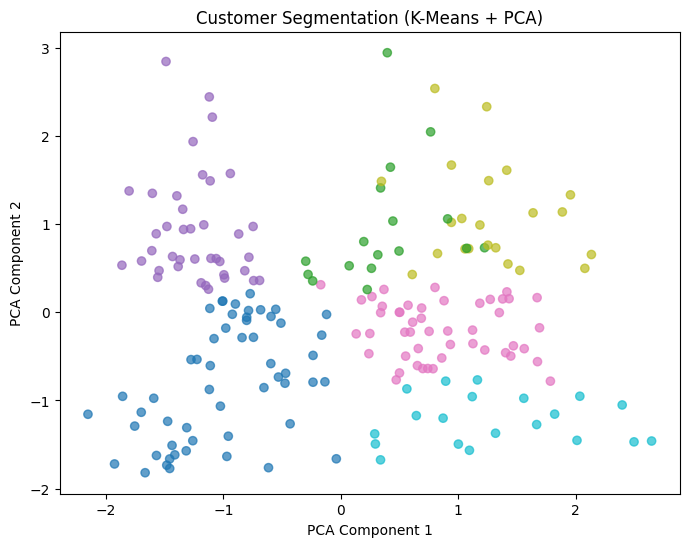


Customer segmentation completed successfully.


In [1]:
# ==========================================================
# CUSTOMER SEGMENTATION USING K-MEANS (FROM SCRATCH)
# GOOGLE COLAB - SINGLE CELL
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import random

# ---------------- CONFIGURATION ----------------
RANDOM_SEED = 42
DATA_URL = "https://raw.githubusercontent.com/Alfukhan0/Mall_customers_dataset/main/Cleaned_Mall_Customers.csv"
MAX_ITER = 300
TOL = 1e-4
MAX_K = 10

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ---------------- K-MEANS IMPLEMENTATION ----------------

def kmeans_plus_plus_init(X, k):
    n = X.shape[0]
    centroids = np.zeros((k, X.shape[1]))
    centroids[0] = X[np.random.randint(n)]

    for i in range(1, k):
        dist_sq = np.min(np.linalg.norm(X[:, None] - centroids[:i], axis=2)**2, axis=1)
        prob = dist_sq / dist_sq.sum()
        centroids[i] = X[np.searchsorted(np.cumsum(prob), np.random.rand())]
    return centroids

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, None] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    new_centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:
            new_centroids[i] = X[np.random.randint(0, X.shape[0])]
        else:
            new_centroids[i] = cluster_points.mean(axis=0)
    return new_centroids

def kmeans(X, k):
    centroids = kmeans_plus_plus_init(X, k)
    for _ in range(MAX_ITER):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if np.linalg.norm(new_centroids - centroids) < TOL:
            break
        centroids = new_centroids
    inertia = np.sum((X - centroids[labels])**2)
    return centroids, labels, inertia

# ---------------- LOAD DATA ----------------

print("Loading Mall Customers Dataset...")
df = pd.read_csv(DATA_URL)
print(df.head())

# ---------------- PREPROCESSING ----------------

df_seg = df.copy()

# Encode Gender if present
if "Gender" in df_seg.columns:
    df_seg["Gender"] = df_seg["Gender"].map({"Male": 0, "Female": 1})

# Drop CustomerID if present
for col in df_seg.columns:
    if "id" in col.lower():
        df_seg.drop(columns=[col], inplace=True)

features = df_seg.select_dtypes(include=np.number)
print("\nFeatures used for segmentation:", list(features.columns))

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(features.values)

# ---------------- FIND OPTIMAL K ----------------

inertias = []
silhouette_scores = []

print("\nEvaluating optimal number of clusters...")

for k in range(2, MAX_K + 1):
    _, labels, inertia = kmeans(X, k)
    inertias.append(inertia)
    sil = silhouette_score(X, labels)
    silhouette_scores.append(sil)
    print(f"K={k} | Inertia={inertia:.2f} | Silhouette={sil:.4f}")

# Plot Elbow & Silhouette
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(2, MAX_K + 1), inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(range(2, MAX_K + 1), silhouette_scores, marker='o')
plt.title("Silhouette Analysis")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")

plt.tight_layout()
plt.show()

# Choose best K
best_k = range(2, MAX_K + 1)[np.argmax(silhouette_scores)]
print("\nOptimal number of clusters selected:", best_k)

# ---------------- FINAL MODEL ----------------

centroids, labels, inertia = kmeans(X, best_k)
df["Customer_Segment"] = labels

# ---------------- CENTROID INTERPRETATION ----------------

centroids_original = scaler.inverse_transform(centroids)
centroid_df = pd.DataFrame(centroids_original, columns=features.columns)
centroid_df.index.name = "Segment"

print("\nCluster Centroids (Original Scale):")
print(centroid_df)

print("\nCustomer count per segment:")
print(df["Customer_Segment"].value_counts().sort_index())

# ---------------- VISUALIZATION (PCA) ----------------

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.title("Customer Segmentation (K-Means + PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

print("\nCustomer segmentation completed successfully.")